In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.colors as col
import matplotlib as mpl
import numpy as np
import scipy as sp
import seaborn as sns
import pandas as pd

In [2]:
plt.rcParams['axes.labelsize'] = 5
plt.rcParams['xtick.labelsize'] = 5
plt.rcParams['ytick.labelsize'] = 5
plt.rcParams['legend.fontsize'] = 5
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Helvetica']

In [3]:
adata = sc.read('./../../data/processed/adata_reannotated_final.h5ad')

In [4]:
import pickle
with open('./../../results/DE/de_stress_new/pickle/new_function.pickle', 'rb') as f:
    de_post_df = pickle.load(f)
    
de_genes = pd.read_pickle('./../../results/DE/de_stress_new/pickle/genes.pickle')
de_genes_sign = de_genes[de_genes['qval']<0.05]
de_genes_sign_mean = de_genes_sign[(de_genes_sign['mean_pert']>0.1) | (de_genes_sign['mean_ctrl']>0.1)]
de_genes_sign_mean = de_genes_sign_mean[np.abs(de_genes_sign_mean['log2fc'])>0.1]

In [5]:
chip_mr = pd.read_pickle('../04-Enrichment/chip_genes_mr_v2.pickle')
chip_gr = pd.read_pickle('../04-Enrichment/chip_genes_gr_v2.pickle')
chip = pd.concat([chip_mr, chip_gr])

In [6]:
genes_mr_blam = chip_mr[chip_mr['condition']=='BLAM'].groupby('gene').size()
genes_mr_blam = list(genes_mr_blam.index[genes_mr_blam >= 3])
genes_mr_blpm = chip_mr[chip_mr['condition']=='BLPM'].groupby('gene').size()
genes_mr_blpm = list(genes_mr_blpm.index[genes_mr_blpm >= 3])
genes_mr = genes_mr_blam + genes_mr_blpm
genes_mr = pd.Series(genes_mr)
genes_mr = genes_mr[genes_mr.isin(adata.var_names)]
len(genes_mr)

997

In [7]:
genes_gr_blam = chip_gr[chip_gr['condition']=='BLAM'].groupby('gene').size()
genes_gr_blam = list(genes_gr_blam.index[genes_gr_blam >= 3])
genes_gr_blpm = chip_gr[chip_gr['condition']=='BLPM'].groupby('gene').size()
genes_gr_blpm = list(genes_gr_blpm.index[genes_gr_blpm >= 3])
genes_gr = genes_gr_blam + genes_gr_blpm
genes_gr = pd.Series(genes_gr)
genes_gr = genes_gr[genes_gr.isin(adata.var_names)]
len(genes_gr)

238

In [8]:
len(set(genes_gr).intersection(set(genes_mr)))

200

In [9]:
genes_tf = pd.concat([genes_gr, genes_mr])
genes_tf = genes_tf.unique()
len(genes_tf)

914

In [10]:
adata[adata.obs.comb.str.contains('Ctrl')]

/app/python3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/app/python3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


View of AnnData object with n_obs × n_vars = 40674 × 17390
    obs: 'knockout', 'line', 'mouse', 'condition', 'sample', 'batch', 'comb', 'n_counts', 'log_counts', 'n_genes', 'hbb_frac', 'ribo_frac', 'mt_frac', 'doublet_score', 'size_factors', 'log_genes', 'louvain_ref', 'louvain_r1', 'louvain_r0.5', 'S_score', 'G2M_score', 'phase', 'louvain_coarse', 'louvain_tmp'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'condition_colors', 'dendrogram_louvain_coarse', 'draw_graph', 'hvg', 'louvain', 'louvain_r0.5_colors', 'louvain_r1_colors', 'neighbors', 'pca', 'phase_colors', 'rank_genes_louvain_coarse', 'rank_genes_louvain_r0.5', 'sample_colors', 'umap'
    obsm: 'X_draw_graph_fa', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [84]:
pseudobulks = {}
adata_ctrl = adata[adata.obs.comb.str.contains('Ctrl')]
adata.obs['louvain_bulk'] = adata.obs['louvain_coarse'].copy().astype(str)
adata.obs['louvain_bulk'][adata.obs['louvain_bulk'].str.contains('Glut')] = 'Glut Neurons'
adata.obs['louvain_bulk'] = adata.obs['louvain_bulk'].astype('category')
for clust in adata.obs.louvain_bulk.cat.categories:
    pseudobulks[clust] = (  
        np.mean(adata_ctrl[adata_ctrl.obs.louvain_bulk==clust].X, axis=0).copy()
    )
    

<ipython-input-84-c2d0d97a9b04>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['louvain_bulk'][adata.obs['louvain_bulk'].str.contains('Glut')] = 'Glut Neurons'


In [85]:
adata_bulk = sc.AnnData(
    X=np.vstack(list(pseudobulks.values())), 
    obs=pd.DataFrame(index=list(pseudobulks.keys())),
    var=adata.var
)

In [86]:
df = pd.DataFrame(pseudobulks)
df.index = adata.var_names


In [87]:
df.loc[genes_tf]

,Astro 1,Astro 2,COPs,Cajal-Retzius,Choroid Plexus,Endothelial,Ependymal,GABA,Glut Neurons,Granule Neuroblasts,MFOLs,Macrophages 1,Macrophages 2,Meningeal,Microglia,NPCs,OPCs,Oligodendrocytes,Pericytes,Vascular
index,,,,,,,,,,,,,,,,,,,,
Dkc1,0.059646,0.019636,0.070964,0.130672,0.117051,0.080597,0.075603,0.079769,0.074617,0.097025,0.080227,0.046693,0.002856,0.062370,0.072629,0.249622,0.085897,0.069448,0.028252,0.030274
Glra3,0.000530,0.001255,-0.000032,-0.000011,-0.000139,0.000247,0.004692,0.003536,0.007836,-0.000033,-0.000061,-0.000049,0.000151,0.000018,0.000407,-0.000039,-0.000013,0.000087,0.001582,-0.000011
Per1,0.084953,0.068401,0.032535,0.039953,0.185540,0.063166,0.370621,0.070817,0.089787,0.012240,0.089434,0.047224,0.069134,0.082330,0.049670,0.020404,0.025239,0.058703,0.040937,0.091012
Vamp2,0.435605,0.284998,0.481156,1.119260,0.179704,0.234907,0.211871,1.269574,1.152749,0.471070,0.842551,0.153389,0.326361,0.438708,0.173886,0.426642,0.363517,0.633845,0.318269,0.470376
Actb,2.215006,1.096964,3.349469,2.185972,2.015250,3.119181,2.515349,1.777852,2.192860,2.826260,3.276359,3.193509,3.862558,2.385754,3.473379,2.945618,2.869202,3.396074,3.091233,3.934512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zfat,0.006000,0.003437,0.003793,0.004206,0.027242,0.001687,0.006844,0.006966,0.018636,0.003066,0.002521,-0.000037,0.000160,0.000029,0.006382,0.003515,0.006552,0.005294,0.000007,0.003080
Zfp365,0.020173,0.015770,0.586647,0.117649,0.036972,0.009929,0.030367,0.214552,0.249774,0.016728,0.551447,0.006725,0.004584,0.009397,0.010873,0.019464,0.102484,0.261150,0.007344,0.015304
Zfp423,0.059611,0.014097,0.004102,0.013255,0.136052,0.039294,0.189581,0.015872,0.015032,0.027288,0.002418,-0.000093,0.000163,0.073215,0.001401,0.015719,0.020191,0.001409,0.001521,0.016677


In [88]:
df_norm = df.apply(lambda x: x/x.max(), axis=1)

In [89]:
df_norm = df_norm.loc[genes_tf]

In [56]:
specific_genes_oligo = df_norm[df_norm['Oligodendrocytes']>0.3].index
specific_genes = df_norm[df_norm['CA3 Glut 2']>0.3].index
specific_genes_astro = df_norm[df_norm['Astro 1']>0.3].index
specific_genes_endothelial = df_norm[df_norm['Endothelial']>0.3].index

In [97]:
specific_genes_oligo = df_norm['Oligodendrocytes'].sort_values(ascending=False)[:200].index
specific_genes = df_norm['Glut Neurons'].sort_values(ascending=False)[:200].index
specific_genes_astro = df_norm['Astro 1'].sort_values(ascending=False)[:200].index
specific_genes_endothelial = df_norm['Endothelial'].sort_values(ascending=False)[:200].index

In [98]:
def plot_heatmap_(de_genes_sign_mean, clust, genes, mask=True, savefig=None):
    plt.ioff()
    de_genes_plot = de_genes[
    (de_genes['gene'].isin(genes))
    & (de_genes['clust']==clust)
    ]
    de_genes_plot = de_genes_plot[
        ~de_genes_plot['test'].isin(['WT_GR','WT_MR'])
    ]
    de_genes_plot['test'] = de_genes_plot['test'].astype('category')
    de_genes_plot['test'] = de_genes_plot['test'].cat.reorder_categories([
        'WT',
        'GR_Nex',
        'GR_Dlx',
        'MR_Nex',
        'MR_Dlx'
    ])
    pivot_mean_pert = de_genes_plot.pivot(columns='test', index='gene', values='mean_pert')
    pivot_mean_ctrl = de_genes_plot.pivot(columns='test', index='gene', values='mean_ctrl')
    pivot_qval = de_genes_plot.pivot(columns='test', index='gene', values='qval')
    pivot_log2fc = de_genes_plot.pivot(columns='test', index='gene', values='log2fc')
    qval_mask = (
        (pivot_qval < 0.05) 
    )
    pivot_log2fc.fillna(value=0, inplace=True)
    idx_sign = np.any(qval_mask==True, axis=1)
    qval_mask = qval_mask[idx_sign]
    pivot_log2fc = pivot_log2fc[idx_sign]
    wt_log_ord = pivot_log2fc['WT']
    wt_log_ord[qval_mask['WT']==False] = 0
    indices_reord = np.argsort(wt_log_ord)
    pivot_log2fc = pivot_log2fc.reindex(pivot_log2fc.index[indices_reord])
    qval_mask = qval_mask.reindex(qval_mask.index[indices_reord])
    pivot_up = pivot_log2fc[pivot_log2fc['WT'] < 0]
    qval_up = qval_mask[pivot_log2fc['WT'] < 0]
    qval_idx = pd.DataFrame(index=qval_up.index)
    qval_idx_2 = pd.DataFrame(index=qval_up.index)
    for i, col in enumerate(qval_up.columns):
        qval_idx[col] = pd.Series(index=qval_up.index, data=(10)*np.ones(len(qval_up)))
        qval_idx_2[col] = pd.Series(index=qval_up.index, data=(i**2)*np.ones(len(qval_up)))
    qval_tot = pd.DataFrame(index=qval_up.index)
    qval_tot['idx_cond'] = qval_idx[qval_up].fillna(0).sum(1)
    qval_tot['idx_within_cond'] = qval_idx_2[qval_up].fillna(0).sum(1)
    qval_tot['log2fc'] = pivot_up[qval_up].fillna(0).sum(1)
    qval_tot = qval_tot.sort_values(['idx_cond', 'idx_within_cond', 'log2fc'], ascending=False)
    indices_reord = qval_tot.index
    pivot_up = pivot_up.reindex(indices_reord)
    qval_up = qval_up.reindex(indices_reord)
    fig, ax = plt.subplots(1, 1, figsize=(0.15*len(pivot_up), 2))
    sns.heatmap(
        pivot_up.T,
        annot=False,
        cmap='RdBu_r',
        center=0,
        ax=ax,
        mask=~qval_up.T if mask==True else None,
        square=True,
        linewidth=.5,
        cbar=False
    )
    ax.set_xlabel('')
    ax.set_ylabel('')
    if savefig is not None:
        fig.savefig(f'heatmaps/{savefig}_down.png', dpi=500, bbox_inches='tight')
        pivot_up[~qval_up] = 0
        pivot_up.to_csv(f'tables/{savefig}_down.csv')
    plt.show()
    pivot_up = pivot_log2fc[pivot_log2fc['WT'] == 0]
    qval_up = qval_mask[pivot_log2fc['WT'] == 0]
    qval_idx = pd.DataFrame(index=qval_up.index)
    qval_idx_2 = pd.DataFrame(index=qval_up.index)
    for i, col in enumerate(qval_up.columns):
        qval_idx[col] = pd.Series(index=qval_up.index, data=(10)*np.ones(len(qval_up)))
        qval_idx_2[col] = pd.Series(index=qval_up.index, data=(i**2)*np.ones(len(qval_up)))
    qval_tot = pd.DataFrame(index=qval_up.index)
    qval_tot['idx_cond'] = qval_idx[qval_up].fillna(0).sum(1)
    qval_tot['idx_within_cond'] = qval_idx_2[qval_up].fillna(0).sum(1)
    qval_tot['log2fc'] = pivot_up[qval_up].fillna(0).sum(1)
    qval_tot = qval_tot.sort_values(['idx_cond', 'idx_within_cond', 'log2fc'], ascending=False)
    indices_reord = qval_tot.index
    pivot_up = pivot_up.reindex(indices_reord)
    qval_up = qval_up.reindex(indices_reord)
    fig, ax = plt.subplots(1, 1, figsize=(0.15*len(pivot_up), 2))
    sns.heatmap(
        pivot_up.T,
        annot=False,
        cmap='RdBu_r',
        center=0,
        vmin=-0.5,
        vmax=0.5,
        ax=ax,
        mask=~qval_up.T if mask==True else None,
        square=True,
        linewidth=.5,
        cbar=False,
    )
    ax.set_xlabel('')
    ax.set_ylabel('')
    if savefig is not None:
        fig.savefig(f'heatmaps/{savefig}_mix.png', dpi=500, bbox_inches='tight')
        pivot_up[~qval_up] = 0
        pivot_up.to_csv(f'tables/{savefig}_mix.csv')
    plt.show()
    pivot_up = pivot_log2fc[pivot_log2fc['WT'] > 0]
    qval_up = qval_mask[pivot_log2fc['WT'] > 0]
    qval_idx = pd.DataFrame(index=qval_up.index)
    qval_idx_2 = pd.DataFrame(index=qval_up.index)
    for i, col in enumerate(qval_up.columns):
        qval_idx[col] = pd.Series(index=qval_up.index, data=(10)*np.ones(len(qval_up)))
        qval_idx_2[col] = pd.Series(index=qval_up.index, data=(i**2)*np.ones(len(qval_up)))
    qval_tot = pd.DataFrame(index=qval_up.index)
    qval_tot['idx_cond'] = qval_idx[qval_up].fillna(0).sum(1)
    qval_tot['idx_within_cond'] = qval_idx_2[qval_up].fillna(0).sum(1)
    qval_tot['log2fc'] = pivot_up[qval_up].fillna(0).sum(1)
    qval_tot = qval_tot.sort_values(['idx_cond', 'idx_within_cond', 'log2fc'], ascending=False)
    indices_reord = qval_tot.index
    pivot_up = pivot_up.reindex(indices_reord)
    qval_up = qval_up.reindex(indices_reord)
    fig, ax = plt.subplots(1, 1, figsize=(0.15*len(pivot_up), 2))
    sns.heatmap(
        pivot_up.T,
        annot=False,
        cmap='RdBu_r',
        center=0,
        vmin=-0.5,
        vmax=0.5,
        ax=ax,
        mask=~qval_up.T if mask==True else None,
        square=True,
        linewidth=.5,
        cbar=False
    )
    ax.set_xlabel('')
    ax.set_ylabel('')
    if savefig is not None:
        fig.savefig(f'heatmaps/{savefig}_up.png', dpi=500, bbox_inches='tight')
        pivot_up[~qval_up] = 0
        pivot_up.to_csv(f'tables/{savefig}_up.csv')
    plt.show()

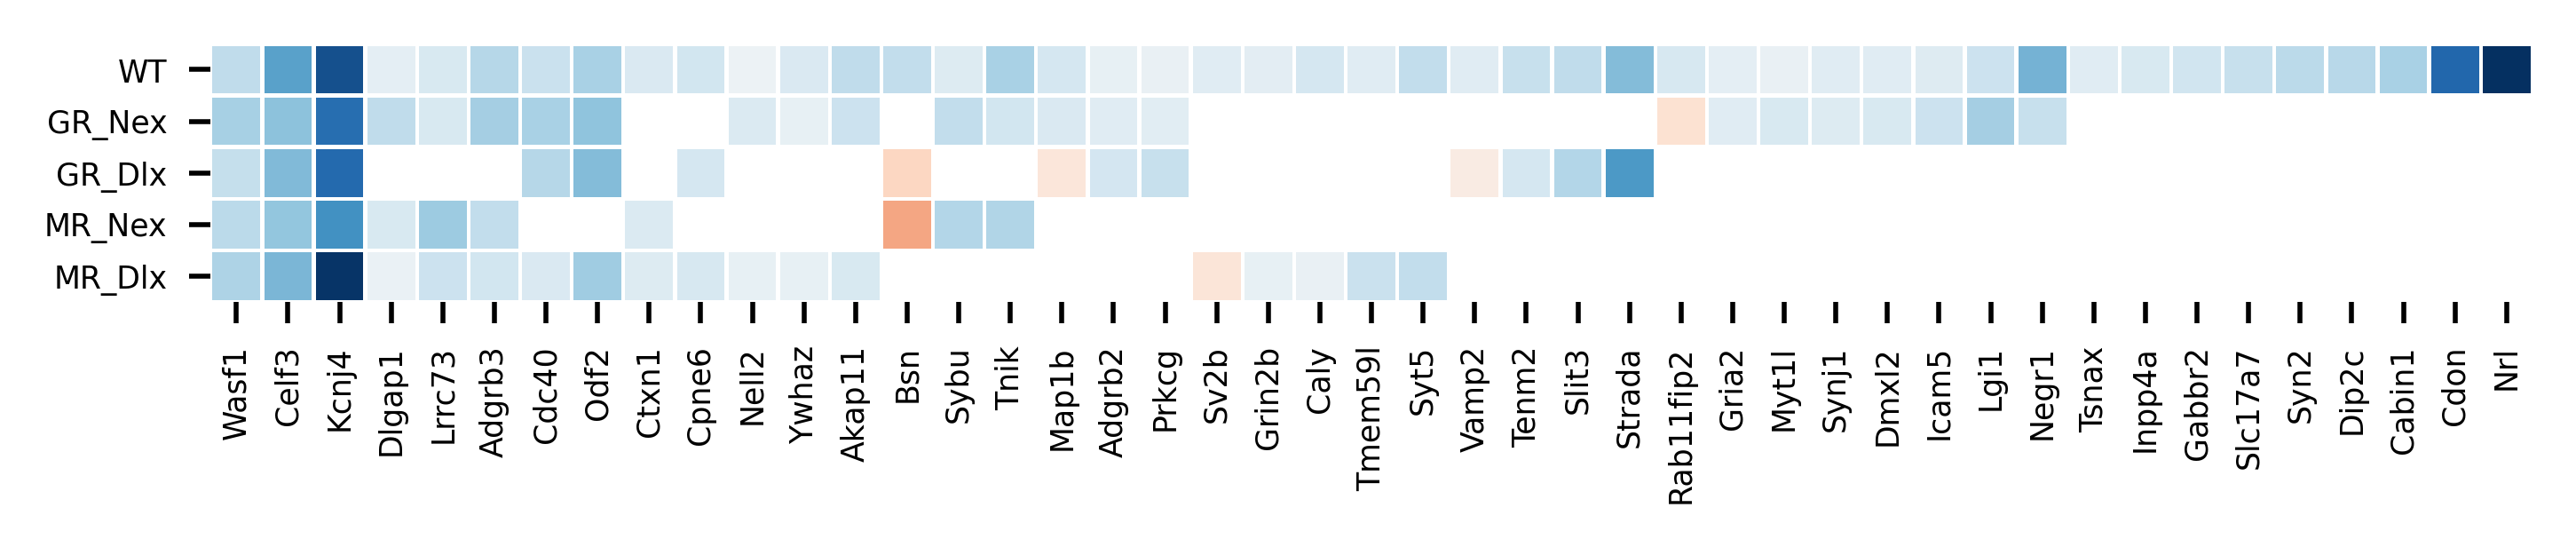

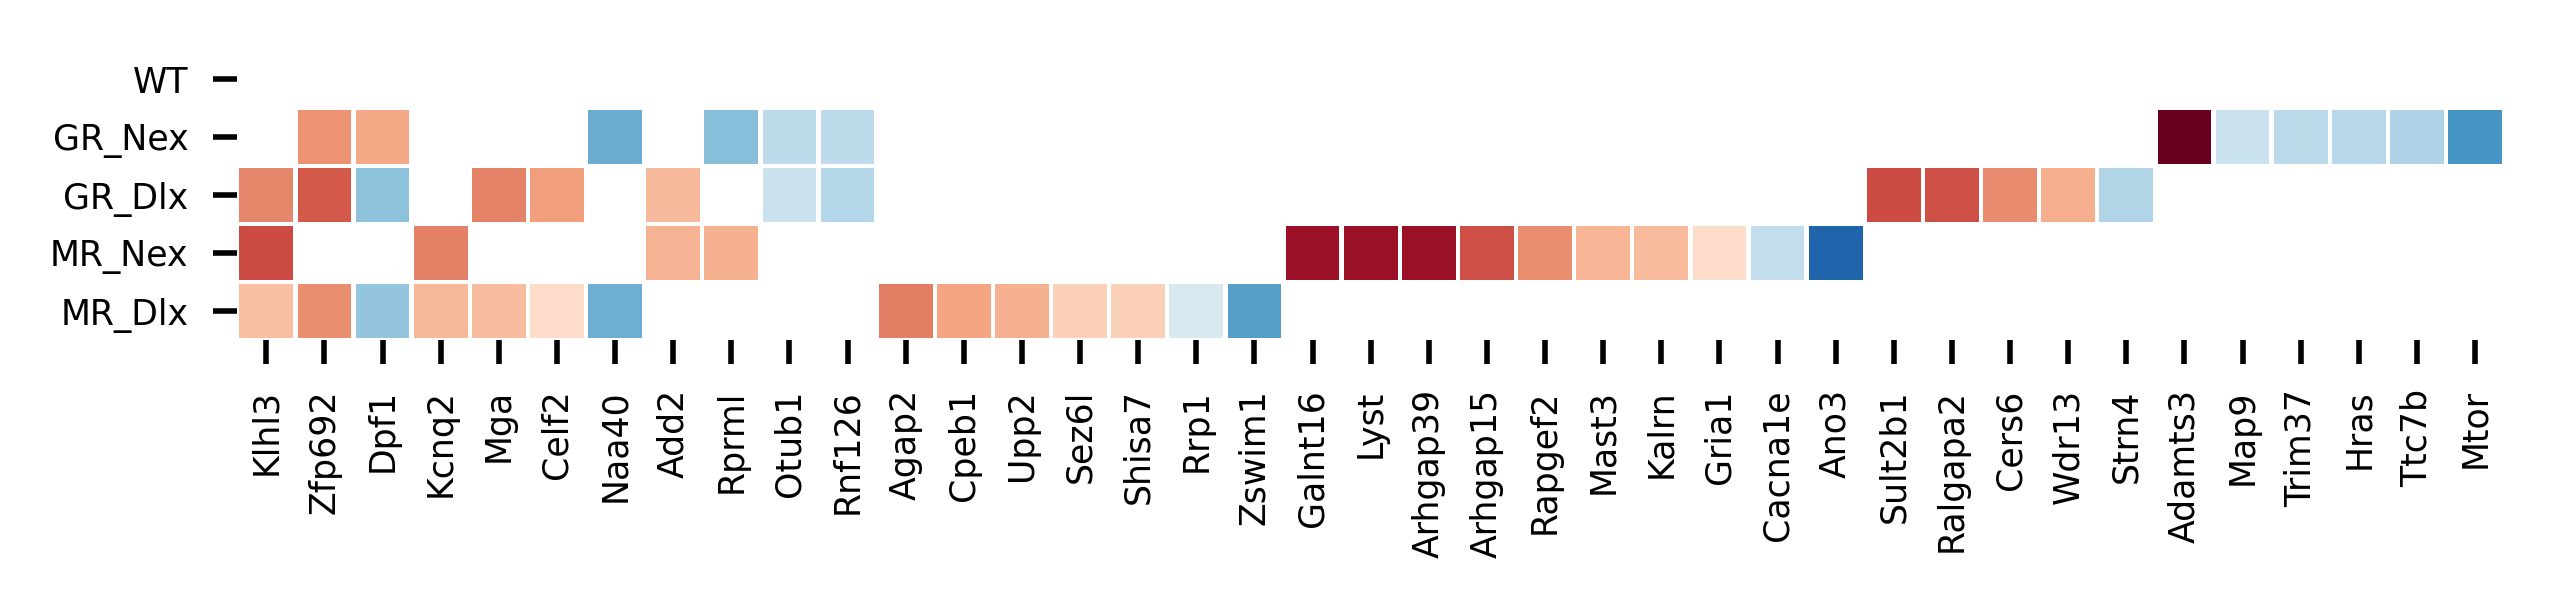

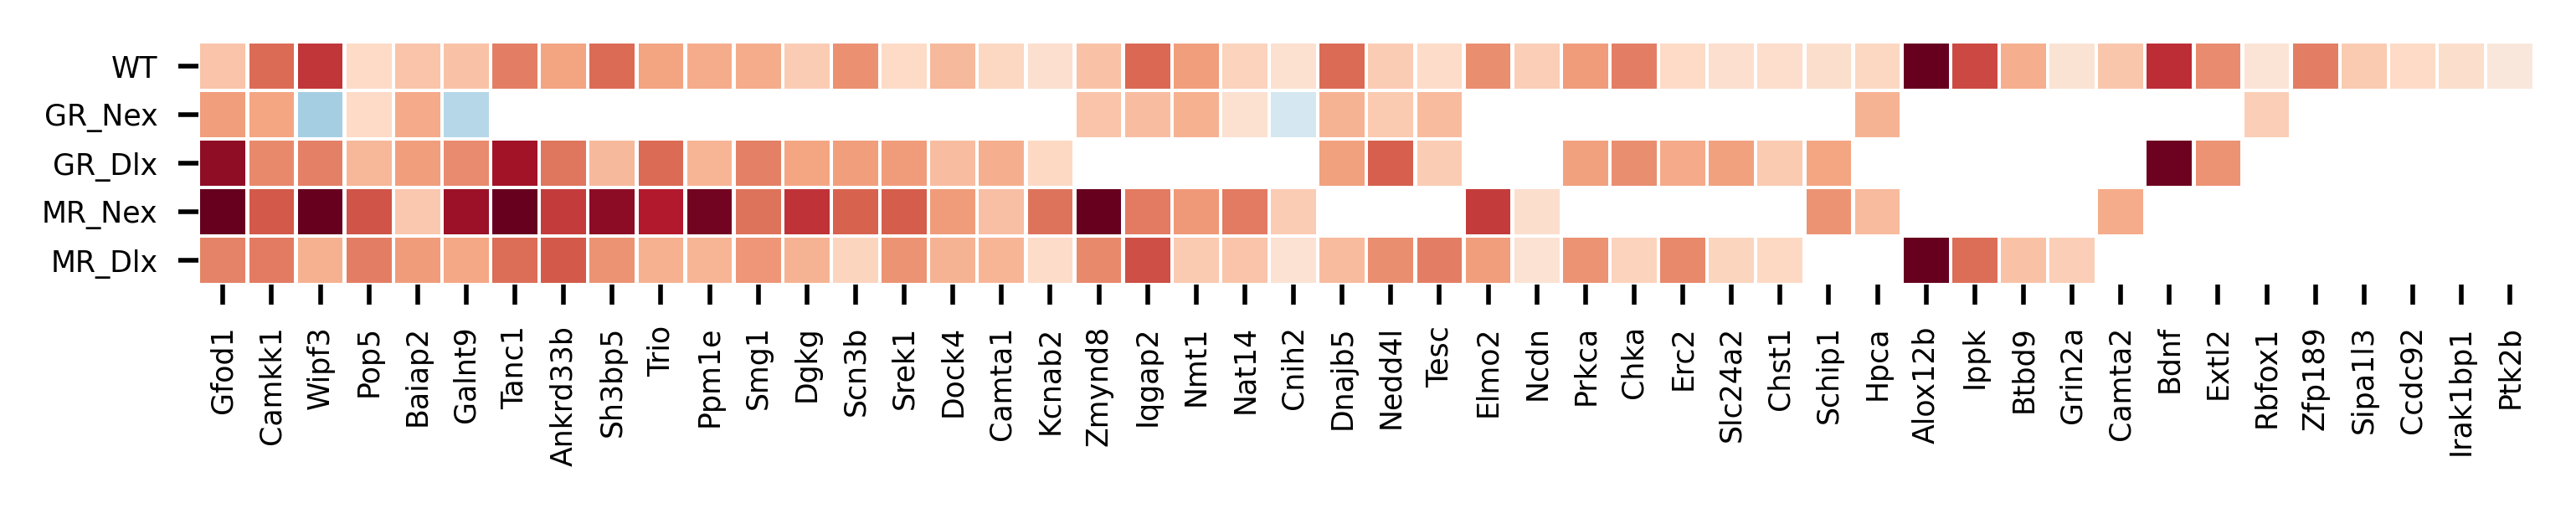

In [99]:
plt.rcParams['figure.dpi'] = 500
plot_heatmap_(de_genes_sign_mean, 'CA1 Glut 2', specific_genes, True, 'CA1Glut2')

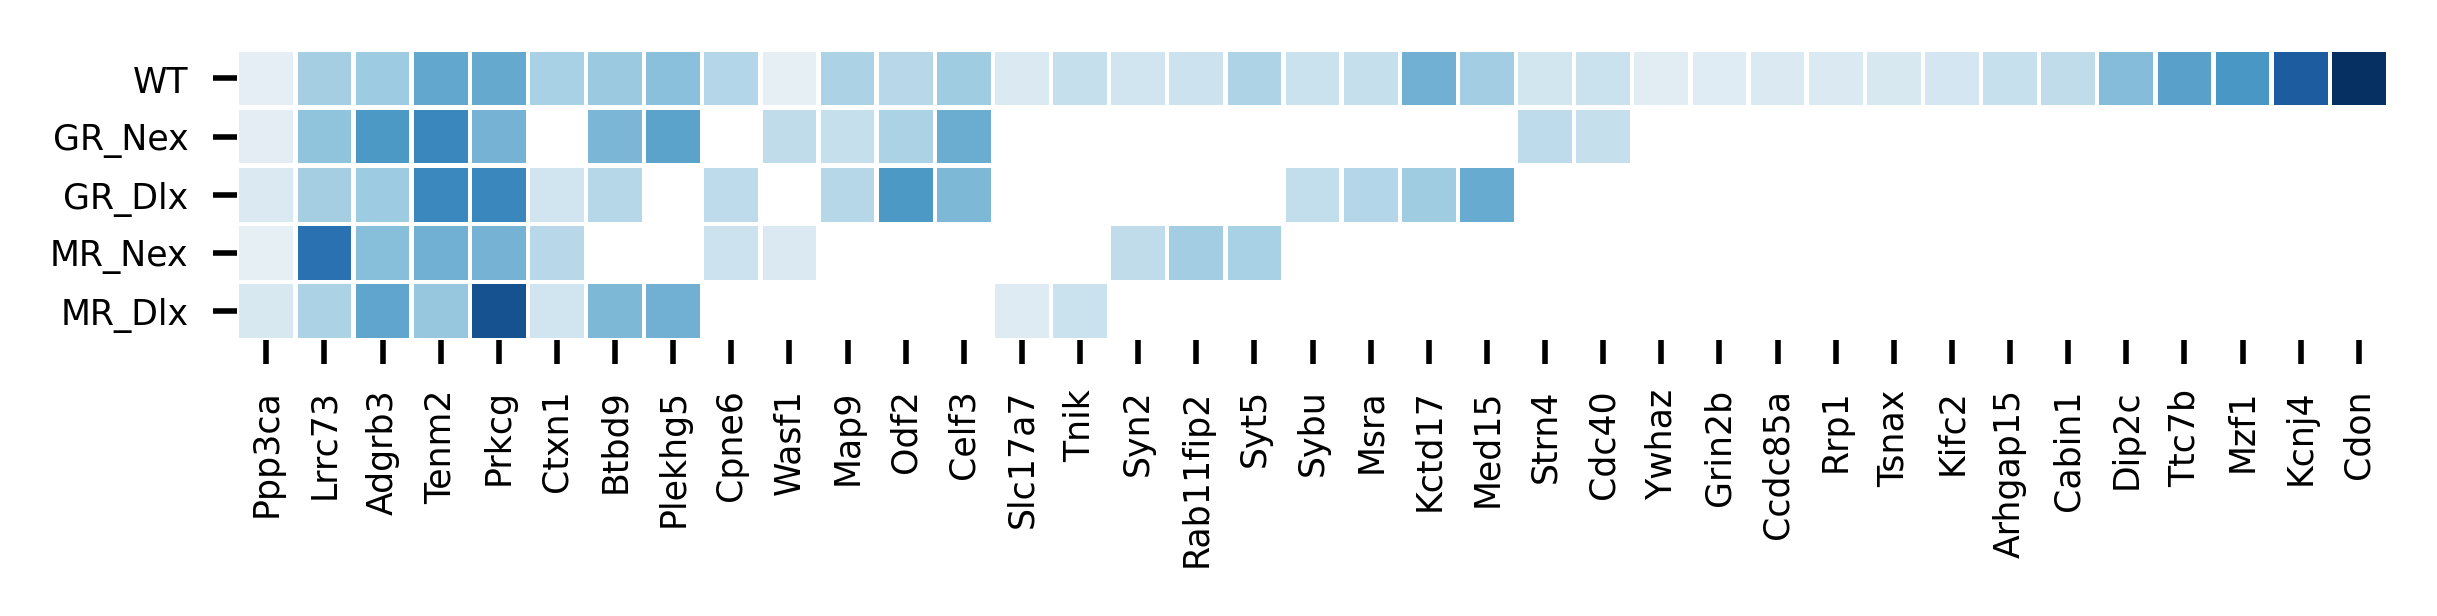

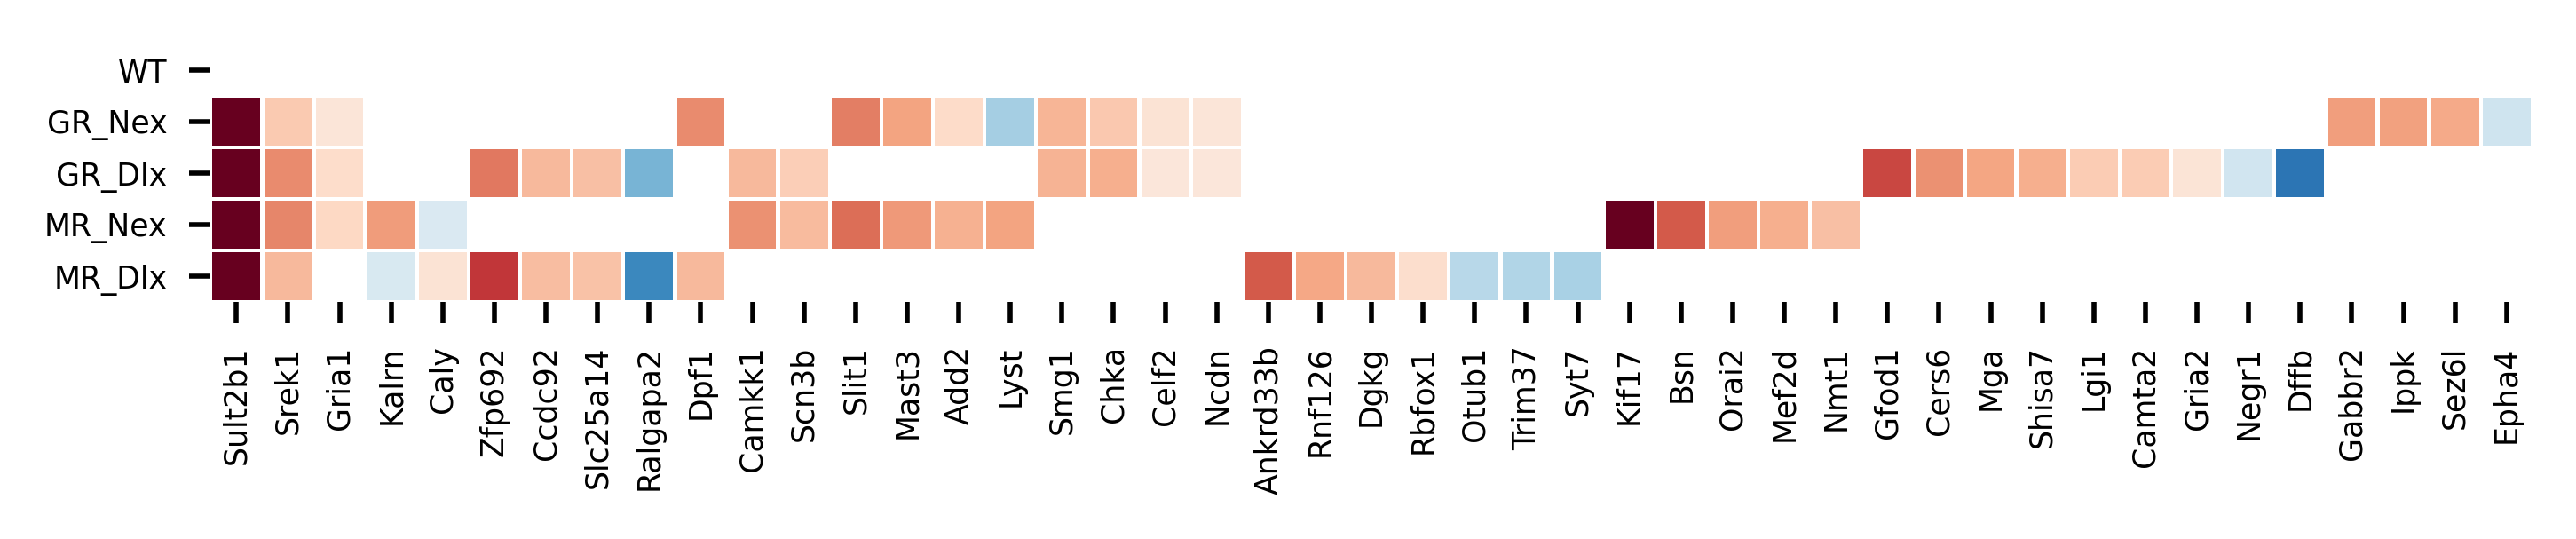

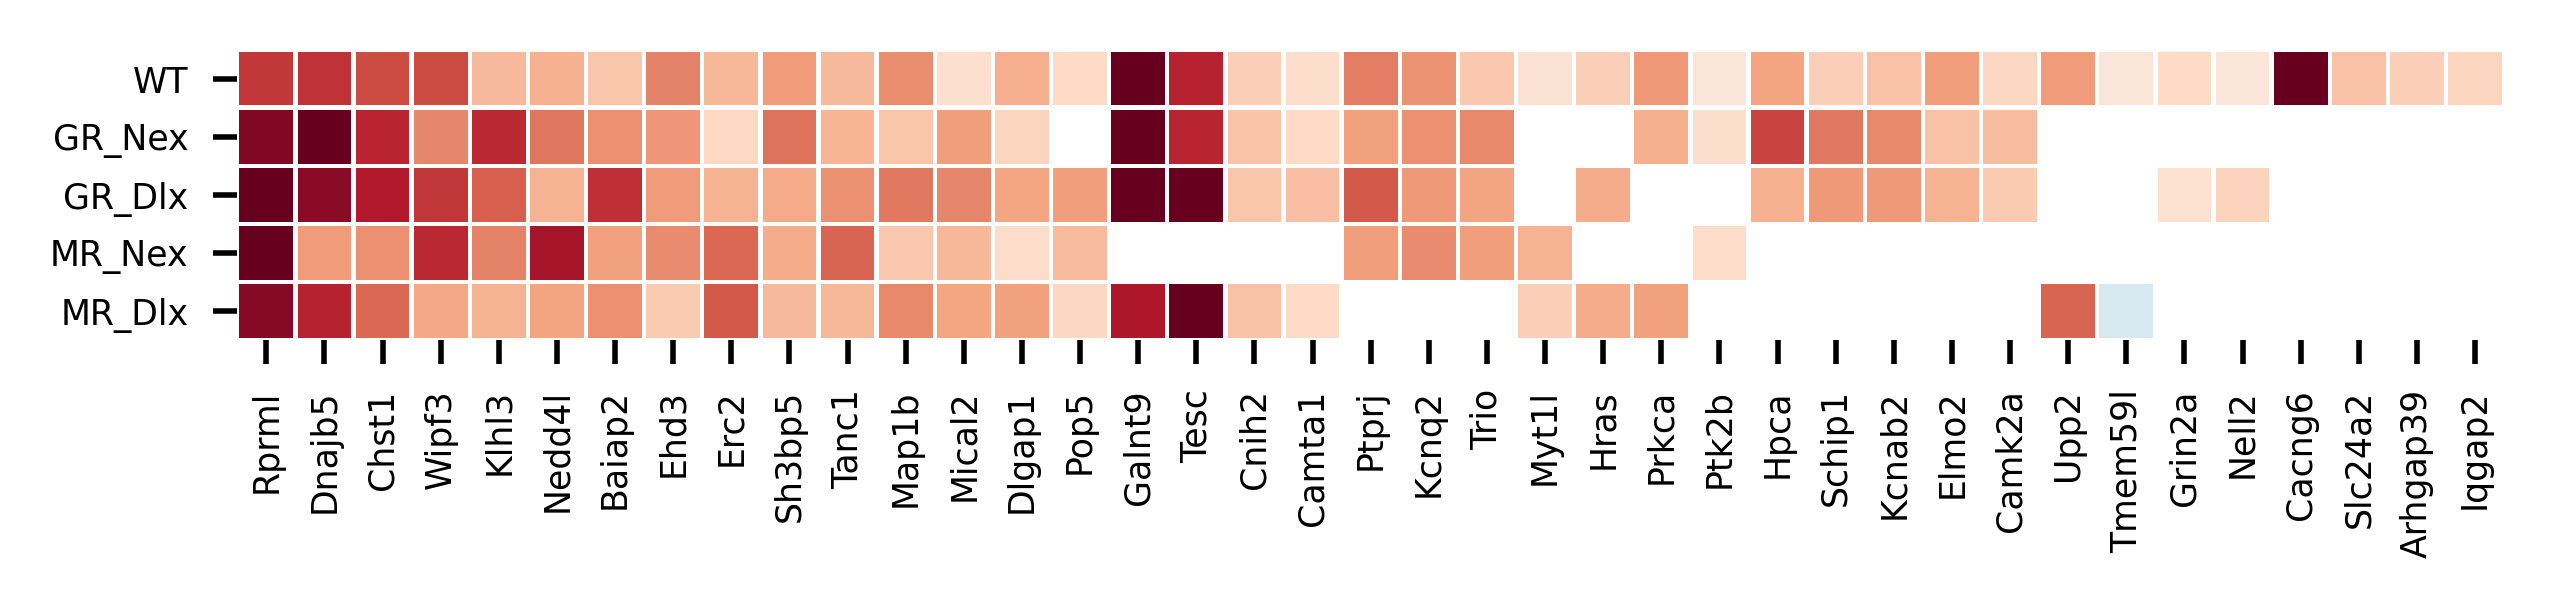

In [100]:
plt.rcParams['figure.dpi'] = 500
plot_heatmap_(de_genes_sign_mean, 'DG Glut 2', specific_genes, True, 'DGGlut2')

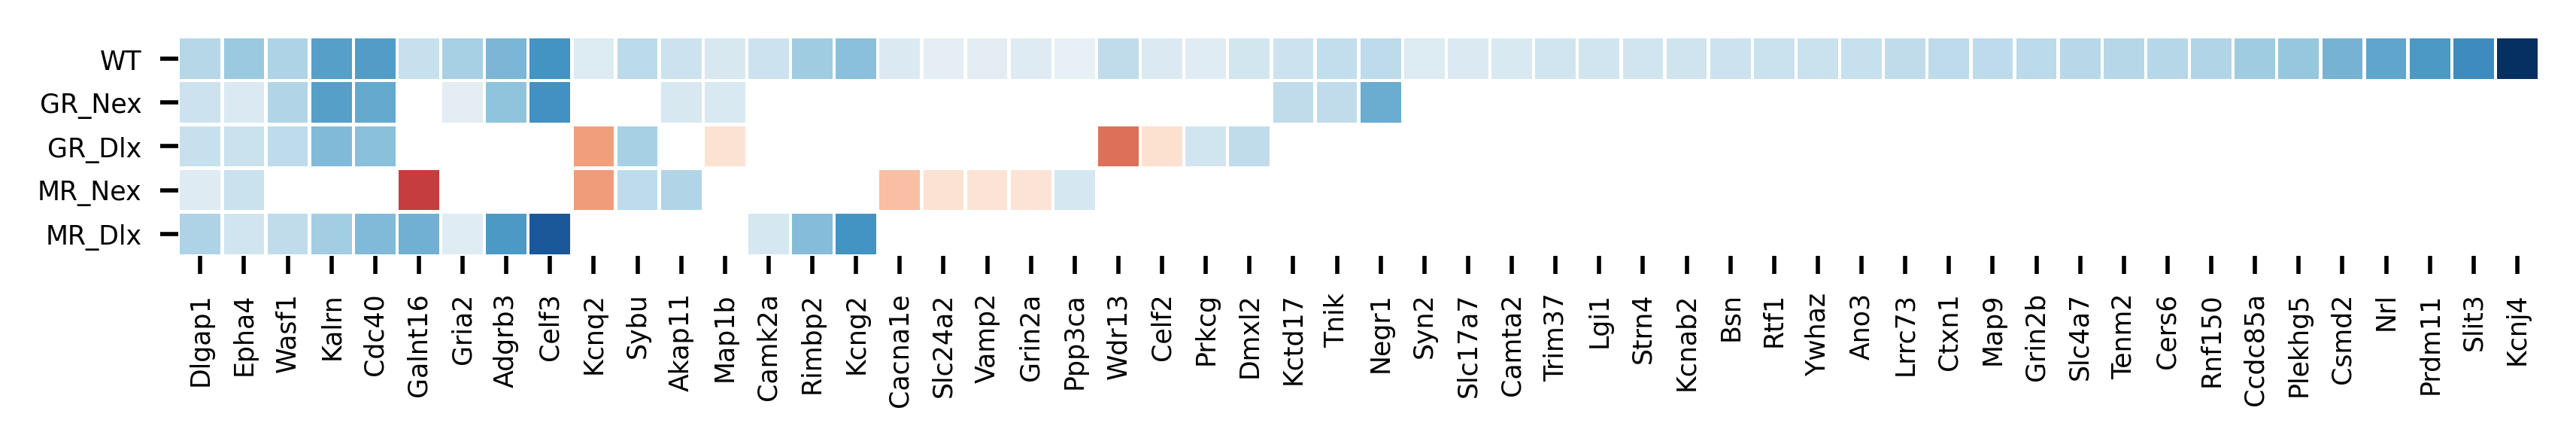

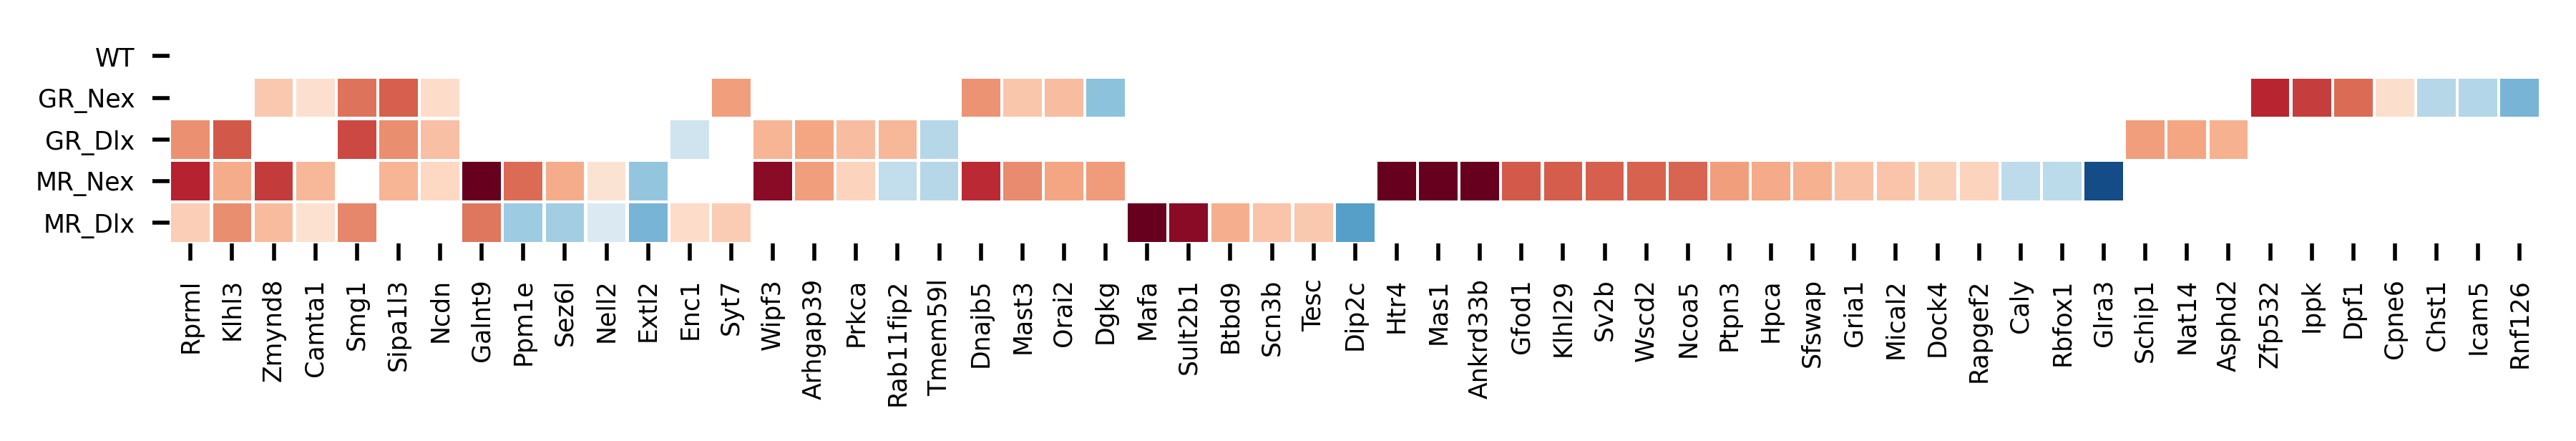

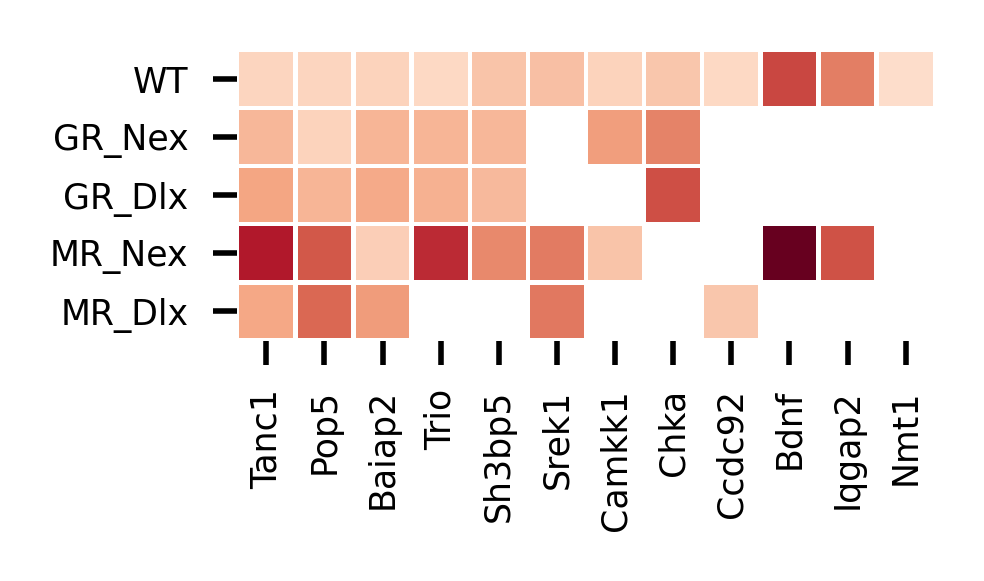

In [101]:
plt.rcParams['figure.dpi'] = 500
plot_heatmap_(de_genes_sign_mean, 'CA3 Glut 2', specific_genes, True, 'CA3Glut2')

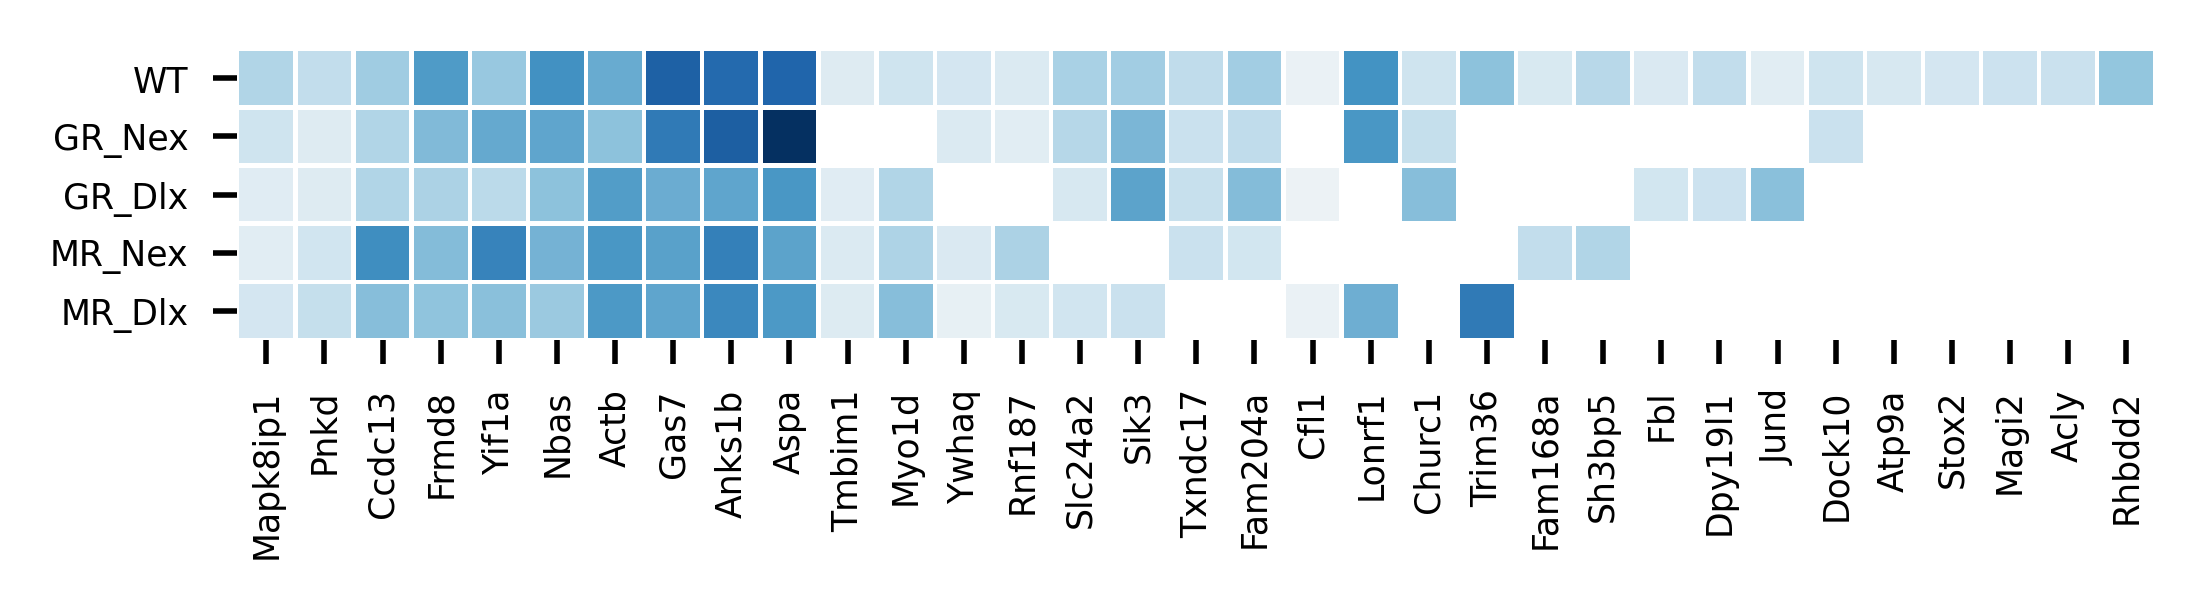

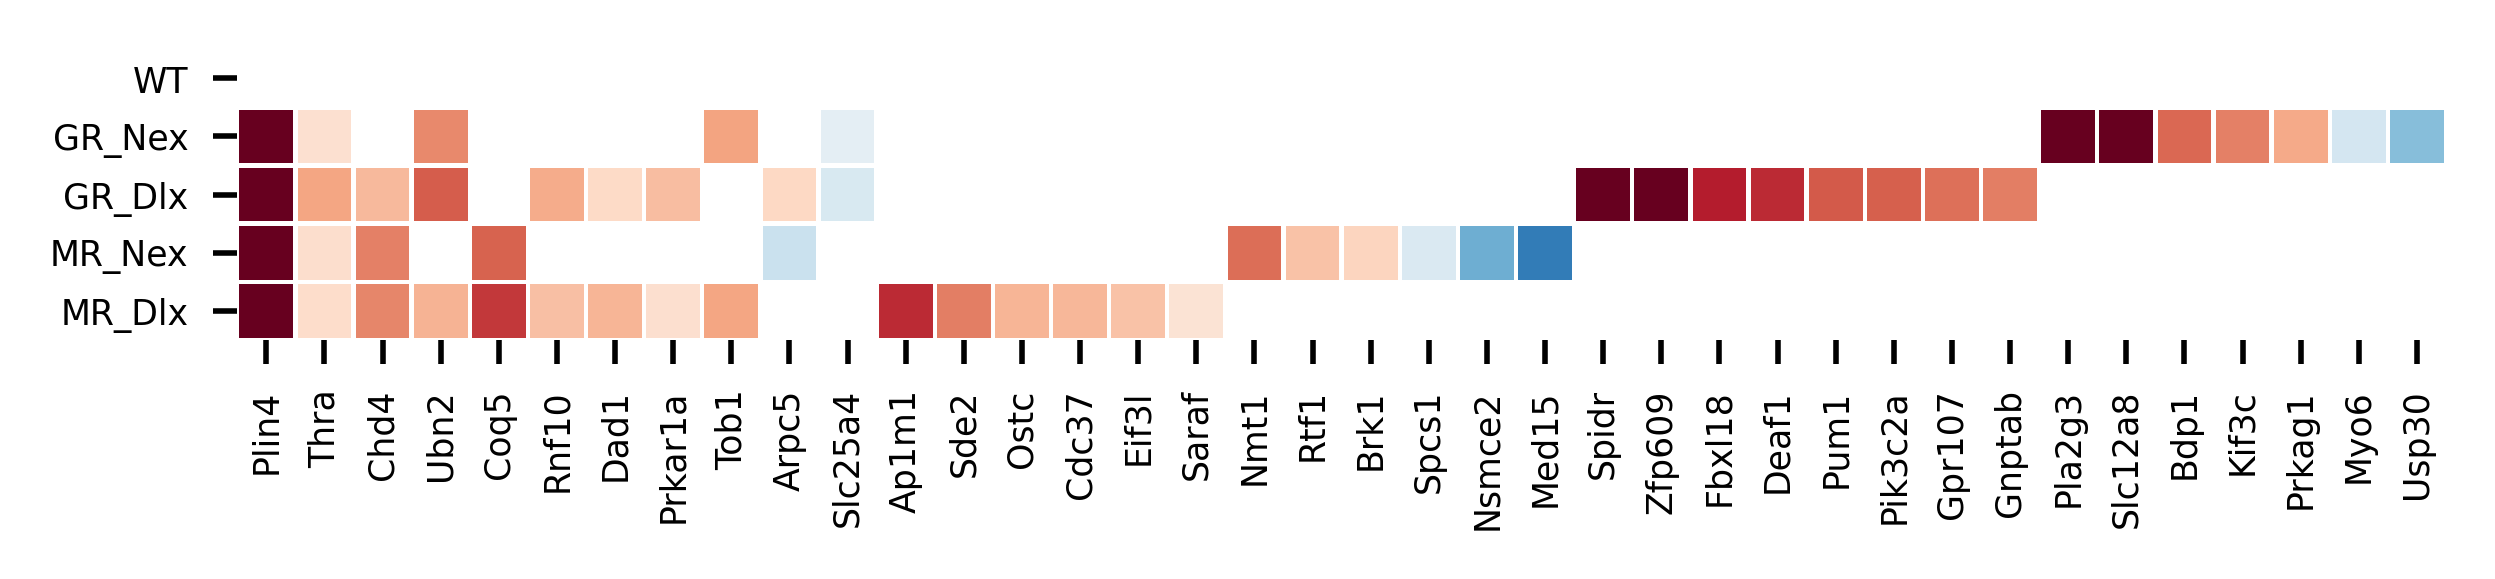

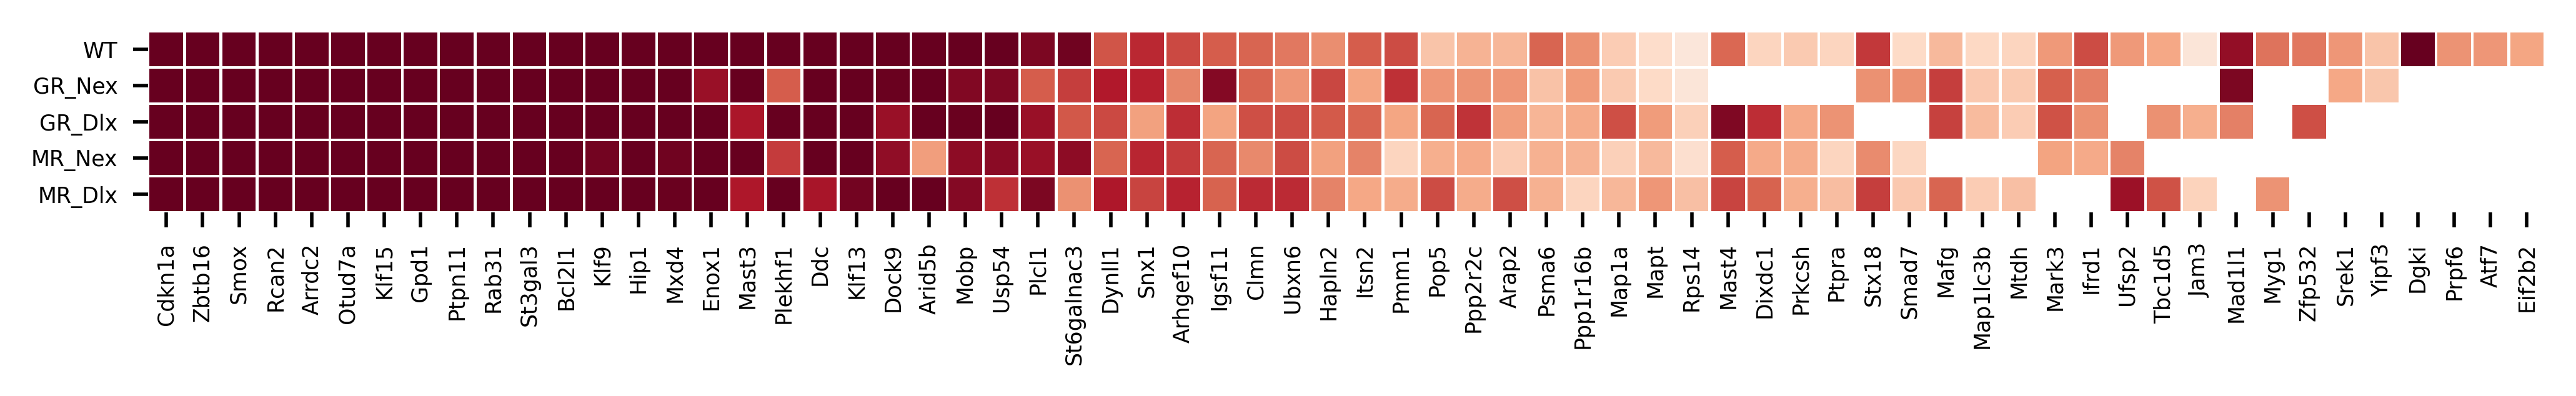

In [102]:
plt.rcParams['figure.dpi'] = 500
plot_heatmap_(de_genes_sign_mean, 'Oligodendrocytes', specific_genes_oligo, True, 'Oligo')

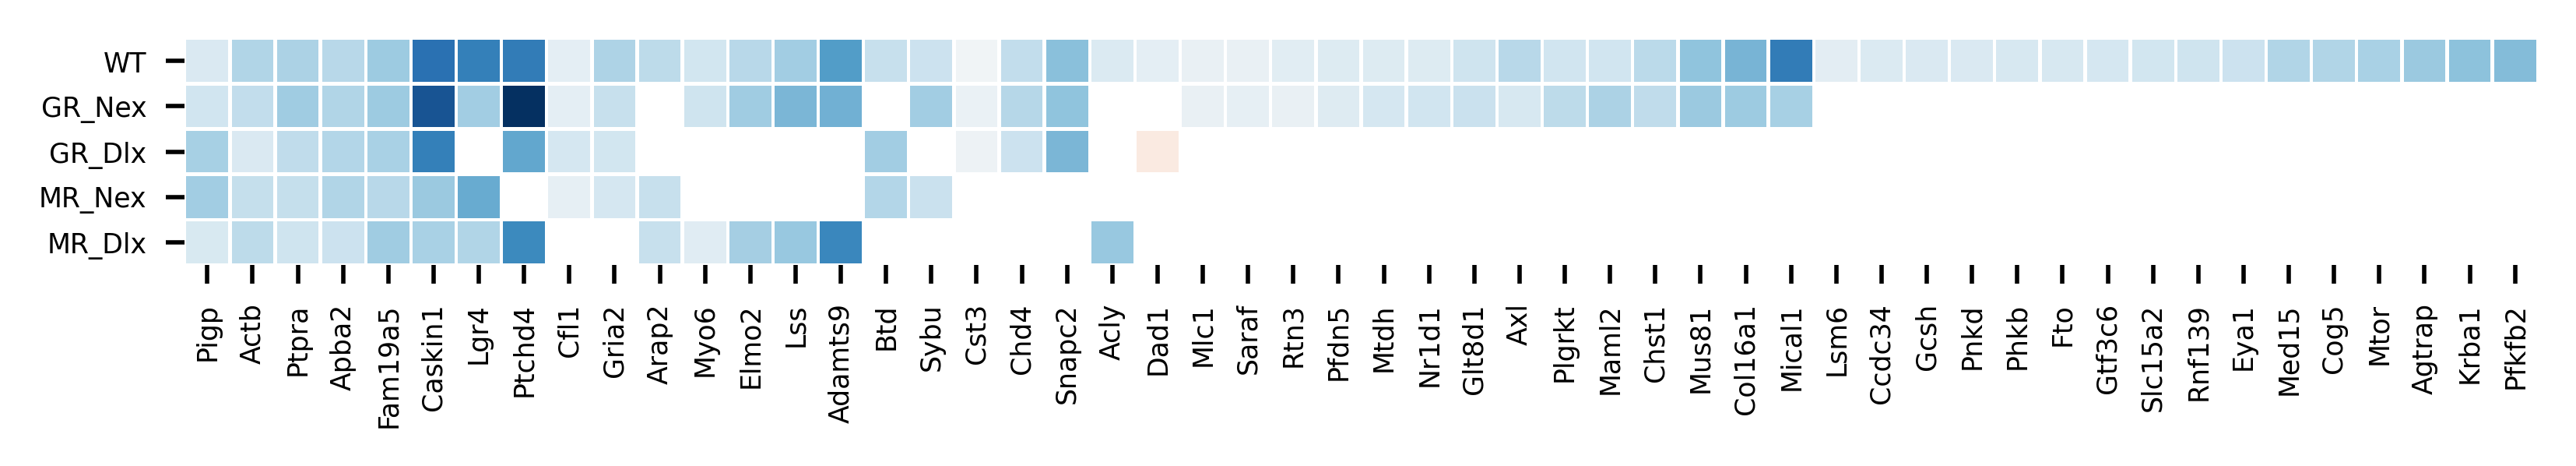

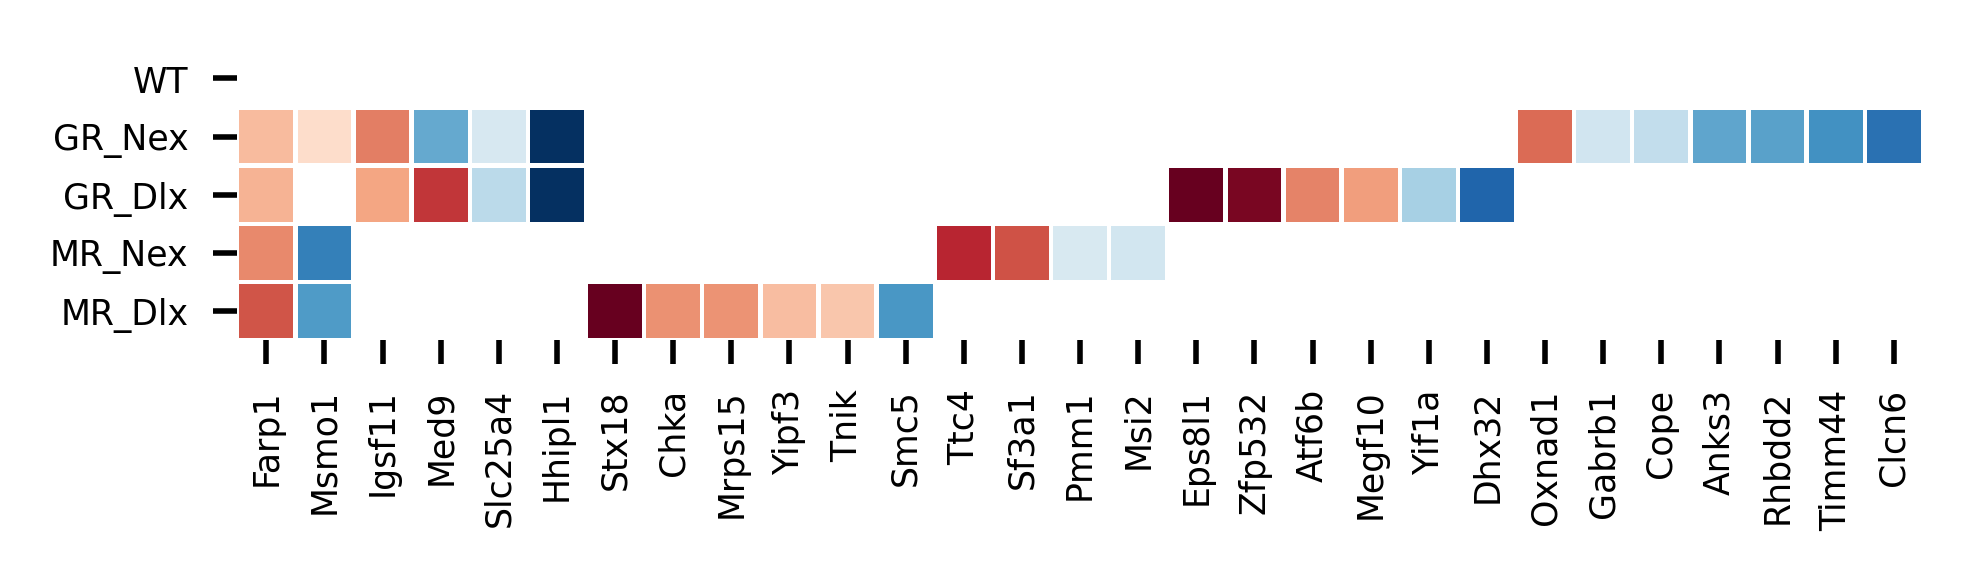

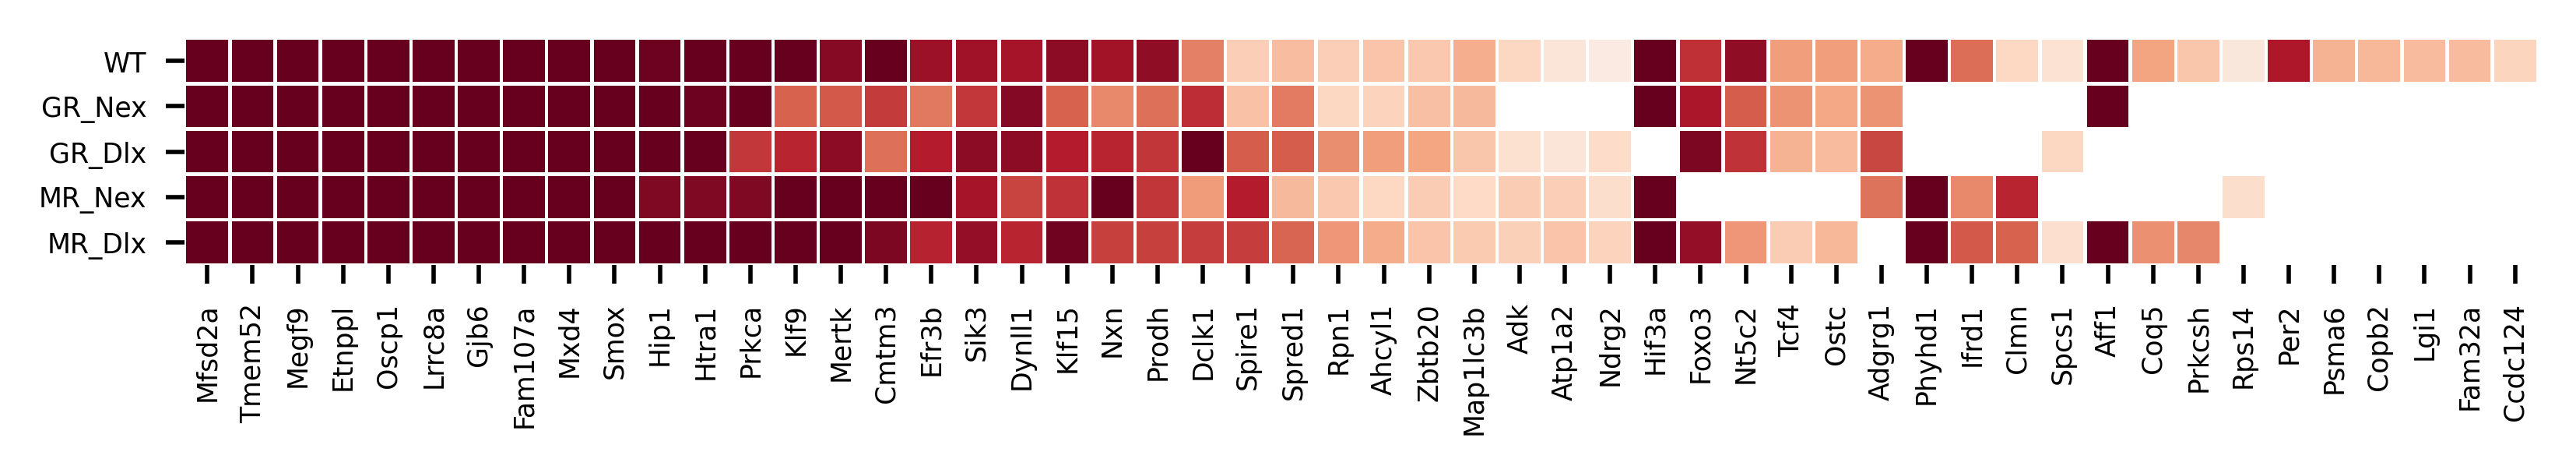

In [103]:
plt.rcParams['figure.dpi'] = 500
plot_heatmap_(de_genes_sign_mean, 'Astro 1', specific_genes_astro, True, 'Astro')

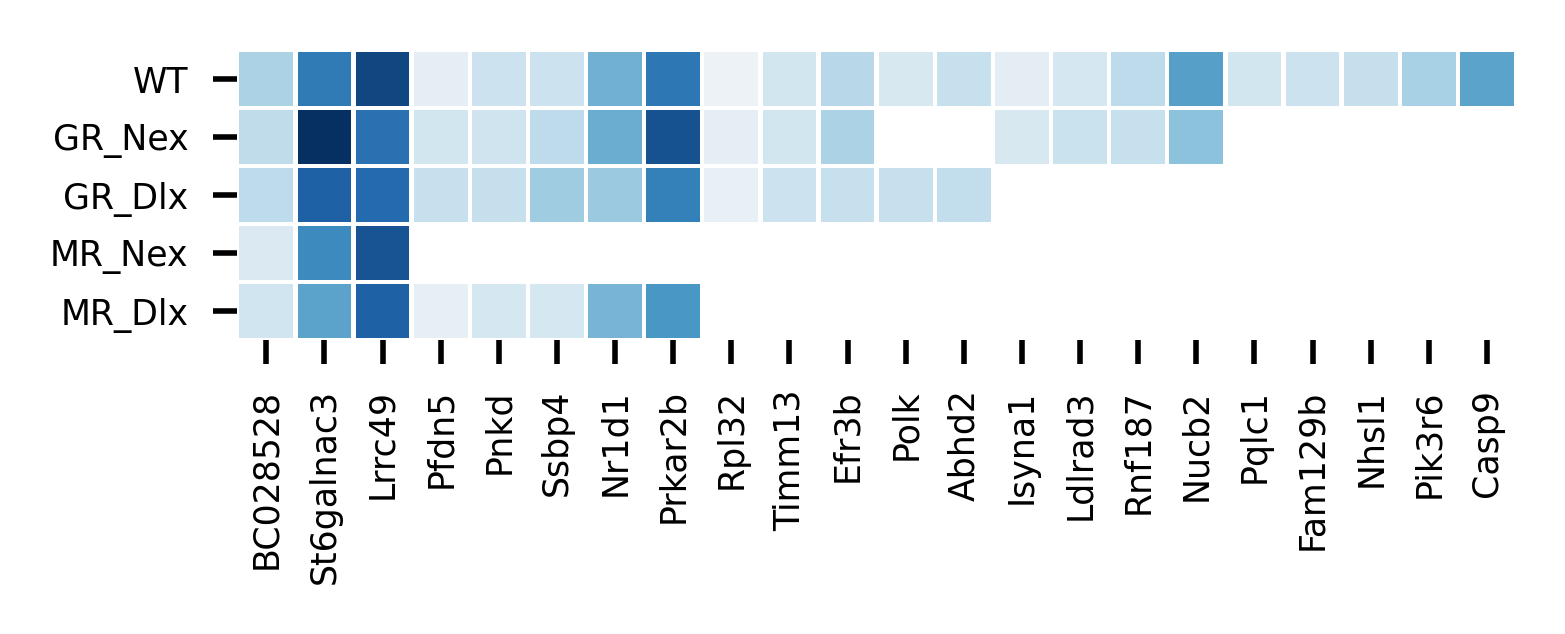

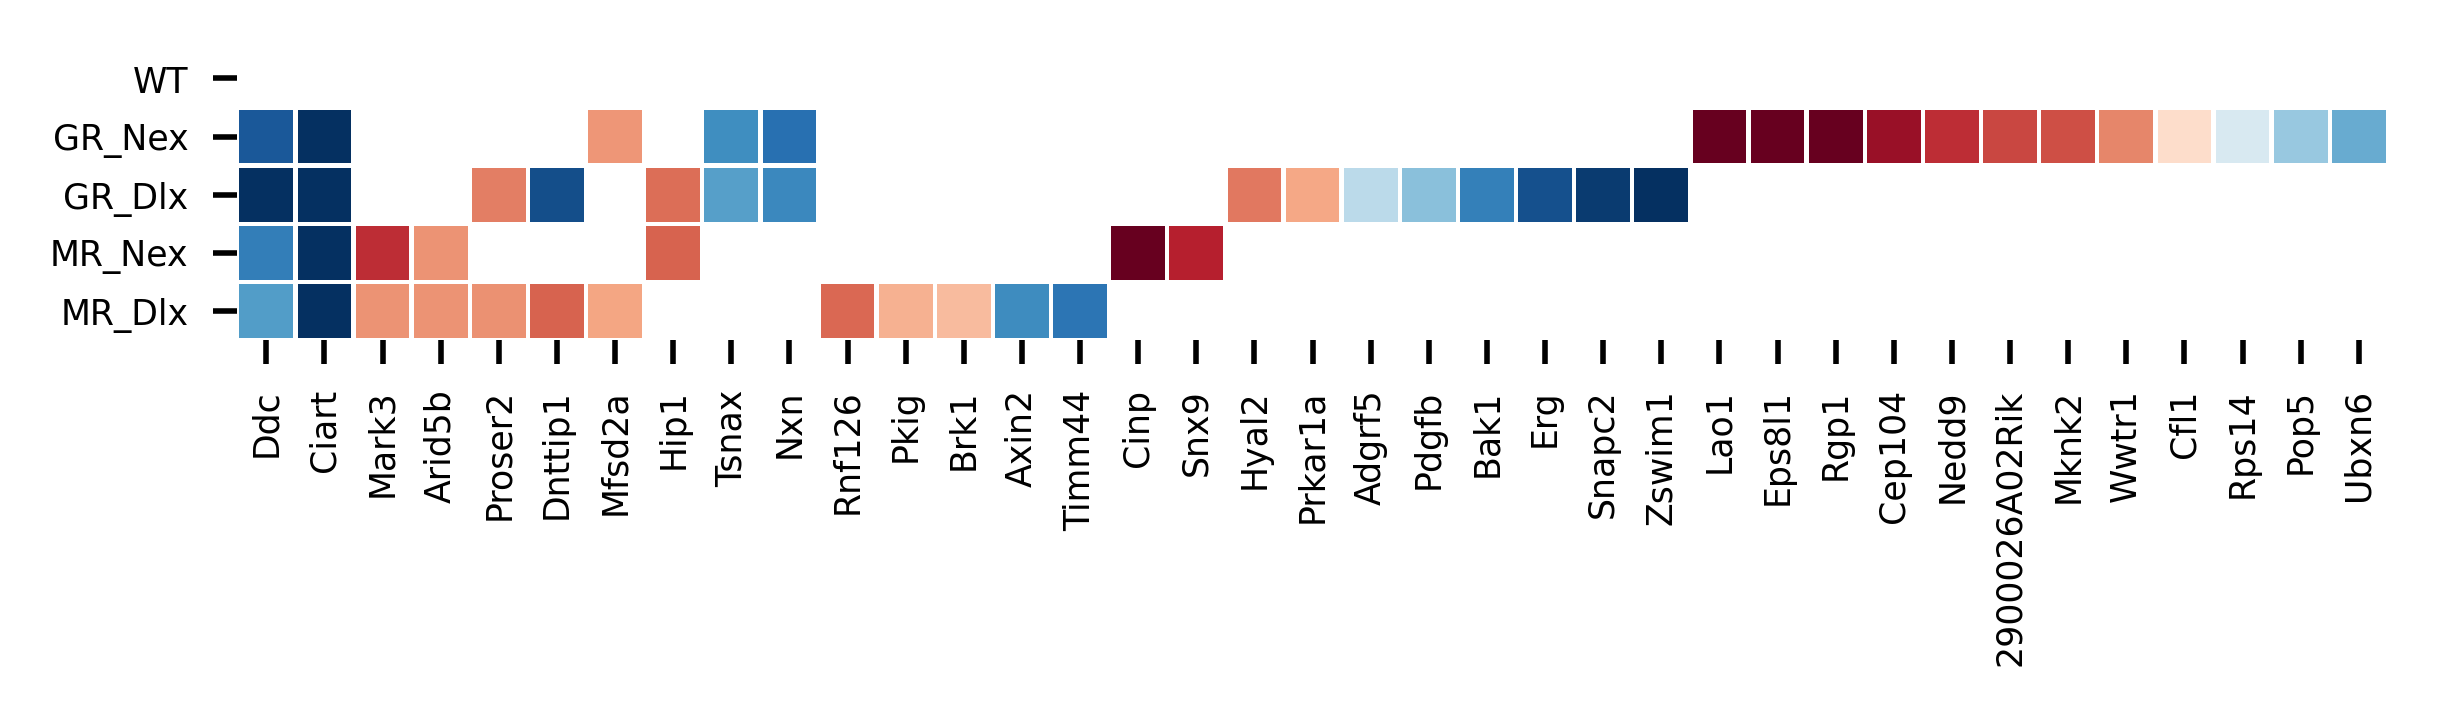

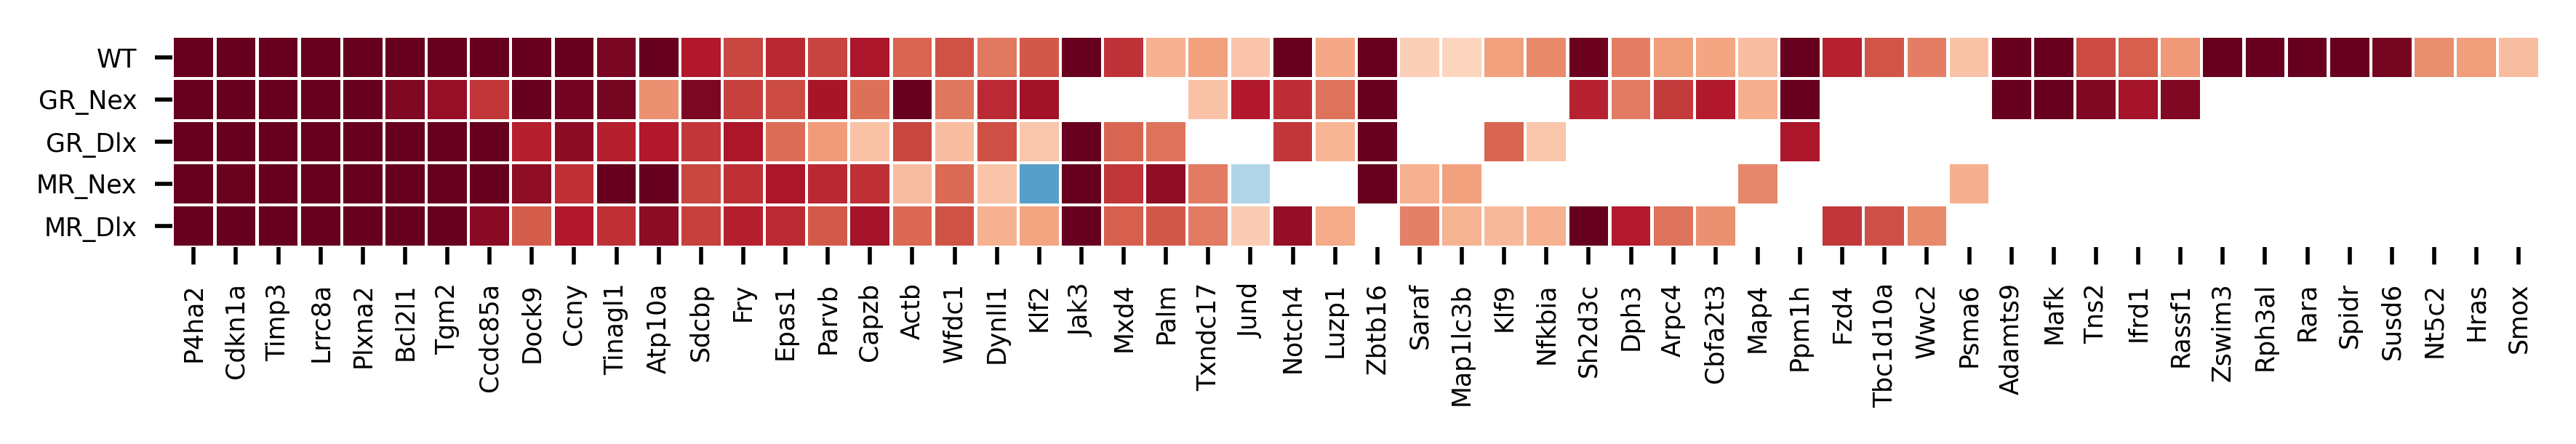

In [104]:
plt.rcParams['figure.dpi'] = 500
plot_heatmap_(de_genes_sign_mean, 'Endothelial', specific_genes_endothelial, True, 'Endothelial')

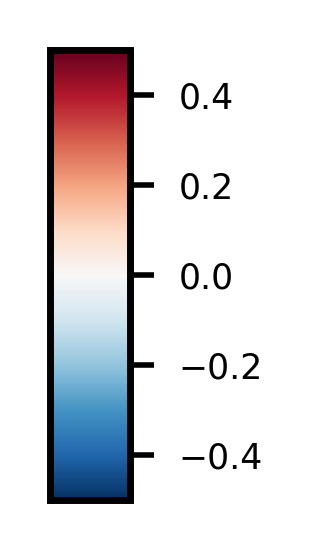

In [105]:
a = np.array([[-0.5,0.5]])
plt.figure(figsize=(0.2, 1.5))
img = plt.imshow(a, cmap="RdBu_r")
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(orientation="vertical", cax=cax)